In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data/features/train.csv', sep=';', index_col=0)

df['foundation_type'] = df['foundation_type'].astype('category')
df['concrete_code'] = df['concrete_code'].astype('category')
df['load_code'] = df['load_code'].astype('category')
df['wind_code'] = df['wind_code'].astype('category')
df['seismic_code'] = df['seismic_code'].astype('category')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1654 entries, 0 to 1653
Data columns (total 78 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   foundation_type             1654 non-null   category
 1   concrete_code               1654 non-null   category
 2   load_code                   1654 non-null   category
 3   wind_code                   1654 non-null   category
 4   seismic_code                1654 non-null   category
 5   floor_number                1654 non-null   int64   
 6   total_height                1654 non-null   float64 
 7   height                      1654 non-null   float64 
 8   foundation_height           1654 non-null   float64 
 9   double_height               1654 non-null   float64 
 10  triple_height               1654 non-null   float64 
 11  support_column              1654 non-null   int64   
 12  unsupported_column          1654 non-null   int64   
 13  walls_number      

## Preparando los datos

In [10]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, make_scorer

In [11]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

# log_pipeline = make_pipeline(
#     SimpleImputer(strategy="median"),
#     FunctionTransformer(np.log, feature_names_out="one-to-one"),
#     StandardScaler())

preprocessing = ColumnTransformer([
        ("cat", cat_pipeline, make_column_selector(dtype_include='category')),
#         ("log", log_pipeline, ["floor_number", "total_height", "height", "foundation_height"]),
    ],
    remainder=default_num_pipeline) 

# Datos de entrada

In [6]:
df = df.drop(['center_x', 'center_y', 'cdm_x', 'cdm_y', 'cdr_x', 'cdr_y'], axis=1)
X = df.drop("reinf_steel_ratio", axis=1)
y = df["reinf_steel_ratio"].copy()

In [7]:
X = df.drop("reinf_steel_ratio", axis=1)
y = df["reinf_steel_ratio"].copy()

In [8]:
len(X.columns)

71

In [9]:
X.columns

Index(['foundation_type', 'concrete_code', 'load_code', 'wind_code',
       'seismic_code', 'floor_number', 'total_height', 'height',
       'foundation_height', 'double_height', 'triple_height', 'support_column',
       'unsupported_column', 'walls_number', 'retaining_walls_number',
       'support_area', 'walls_area', 'retaining_walls_area', 'LL', 'DL',
       'LL_max', 'DL_max', 'wind_load_x', 'wind_load_y', 'seismic_acc',
       'slab_total_area', 'flat_slab_area', 'waffle_slab_area', 'depth',
       'drop_panel_area', 'domes_area', 'domes_number', 'inter_axis_distance',
       'shape_factor', 'x_length', 'y_length', 'concrete_m3_ratio',
       'slab_area_mean', 'height_mean', 'double_height_ratio',
       'triple_height_ratio', 'slenderness', 'column_area', 'swall_num',
       'swall_area', 'swall_area_mean', 'col_area_mean', 'rwalls_area_mean',
       'swall_area_mean_m2', 'col_area_mean_m2', 'rwalls_area_mean_m2',
       'swall_area_ratio', 'col_area_ratio', 'rwals_area_ratio', 

# ElasticNet

In [26]:
# ela_net_reg = TransformedTargetRegressor(make_pipeline(preprocessing, ElasticNet(alpha=0.1, l1_ratio=0.5)), transformer=StandardScaler())
ela_net_reg = make_pipeline(preprocessing, ElasticNet())
ela_net_reg_mapes = cross_val_score(ela_net_reg, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)

In [27]:
pd.Series(ela_net_reg_mapes).describe()

count    10.000000
mean      0.138287
std       0.021801
min       0.109685
25%       0.121311
50%       0.136039
75%       0.148887
max       0.181493
dtype: float64

In [28]:
from sklearn.model_selection import learning_curve

def train_and_plot_learning_curve(model, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(model, X, y, 
                                                             train_sizes = np.linspace(0.01, 1.0, 40), 
                                                             cv=5,
                                                             scoring=make_scorer(mean_absolute_percentage_error),
                                                            n_jobs=-1)
    train_errors = train_scores.mean(axis=1)
    valid_errors = valid_scores.mean(axis=1)

    plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
    plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
    # beautify the figure: add labels, axis, grid, and legend
    plt.show()

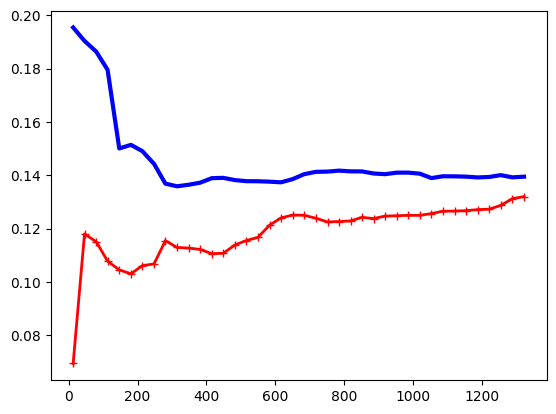

CPU times: user 1.07 s, sys: 1.31 s, total: 2.37 s
Wall time: 2.01 s


In [29]:
%%time
train_and_plot_learning_curve(ela_net_reg, X, y)

# RandomForestRegressor

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
tree_cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))

tree_default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"))

tree_preprocessing = ColumnTransformer([
        ("cat", tree_cat_pipeline, make_column_selector(dtype_include='category')),
    ],
    remainder=tree_default_num_pipeline,
    verbose_feature_names_out=False,
) 

In [17]:
forest_reg = make_pipeline(tree_preprocessing,
                          RandomForestRegressor(random_state=42))
# forest_reg = TransformedTargetRegressor(make_pipeline(preprocessing, RandomForestRegressor(random_state=42)), transformer=StandardScaler())


In [18]:
%%time
forest_reg_mapes = cross_val_score(forest_reg, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)
pd.Series(forest_reg_mapes).describe()

CPU times: user 24.2 s, sys: 0 ns, total: 24.2 s
Wall time: 24.2 s


count    10.000000
mean      0.106547
std       0.012296
min       0.087010
25%       0.100814
50%       0.107168
75%       0.117048
max       0.121292
dtype: float64

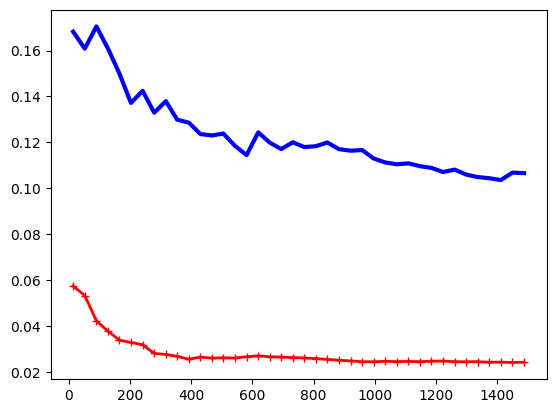

CPU times: user 1.47 s, sys: 473 ms, total: 1.94 s
Wall time: 1min 6s


In [19]:
%%time
train_and_plot_learning_curve(forest_reg)

In [20]:
sorted(zip(forest_reg['randomforestregressor'].feature_importances_, tree_preprocessing.get_feature_names_out()), reverse=True)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Histogram-Based Gradient Boosting

In [44]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import LinearSVR

In [18]:
hgbr_cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan))

hgbr_default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"))

hgbr_preprocessing = ColumnTransformer([
        ("cat", hgbr_cat_pipeline, make_column_selector(dtype_include='category')),
    ],
    remainder=hgbr_default_num_pipeline,
    verbose_feature_names_out=False,
) 

In [69]:
categorical_columns = X.select_dtypes(include="category").columns
hgbr_reg = make_pipeline(hgbr_preprocessing,
                         SequentialFeatureSelector(HistGradientBoostingRegressor(max_iter=50, random_state=42), 
                                                   n_features_to_select=20, direction="forward"),
                           HistGradientBoostingRegressor(max_iter=1000, random_state=42)
                        ).set_output(transform="pandas")

In [70]:
%%time

hgbr_reg_mapes = cross_val_score(HistGradientBoostingRegressor(max_iter=1000, random_state=42), 
                                 X_fea_selected, y, scoring=make_scorer(mean_absolute_percentage_error), cv=5)
pd.Series(hgbr_reg_mapes).describe()

CPU times: user 3min 10s, sys: 660 ms, total: 3min 10s
Wall time: 12.1 s


count    5.000000
mean     0.089010
std      0.004783
min      0.082111
25%      0.086861
50%      0.090100
75%      0.091193
max      0.094785
dtype: float64

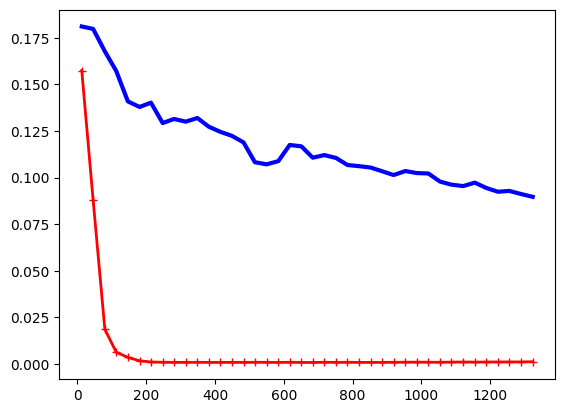

In [68]:
train_and_plot_learning_curve(HistGradientBoostingRegressor(max_iter=1000, random_state=42), X_fea_selected, y)

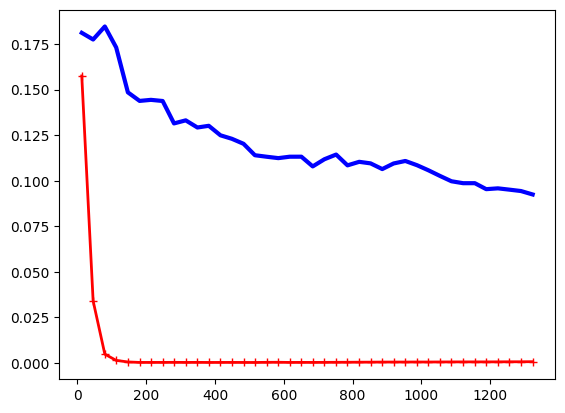

CPU times: user 1.14 s, sys: 244 ms, total: 1.38 s
Wall time: 2min 57s


In [25]:
%%time
train_and_plot_learning_curve(hgbr_reg)

In [37]:
%%time

parameters = {
 'histgradientboostingregressor__max_iter': [1000, 1200, 1500, 2000],
 'histgradientboostingregressor__learning_rate': [0.05, 0.1, 0.2],
 'histgradientboostingregressor__max_depth' : [25, 50, 75],
 'histgradientboostingregressor__max_leaf_nodes' : [20, 31, 40],
 'histgradientboostingregressor__min_samples_leaf' : [10, 20, 30],
 'histgradientboostingregressor__l2_regularization': [0, 1, 1.5],
 }
#instantiate the gridsearch
hgb_grid = GridSearchCV(hgbr_reg, parameters, n_jobs=-1, 
 cv=10, scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))
#fit on the grid 
hgb_grid.fit(X, y)

CPU times: user 2min 15s, sys: 19.9 s, total: 2min 35s
Wall time: 5h 13min 49s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median'))]),
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinalencoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan))]),
                                                                         <s...
                         'histgradientboostingregressor__learning_rate': [0.05,
                                                                          0.1,
                                                                          0.2],
                         'histgradientboostingregressor__max_depth': [25, 50,
                                                                      75],
                         'histgradientboostingregressor__max_iter': [1000, 1200,
                                                                     1500,
                                                                     2000],
                         'histgradientboostingregressor__max_leaf_nodes': [20,
                                                                           31,
                                                                           40],
                         'histgradientboostingregressor__min_samples_leaf': [10,
                                                                             20,
                                                                             30]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [38]:
hgb_grid.best_params_

{'histgradientboostingregressor__l2_regularization': 0,
 'histgradientboostingregressor__learning_rate': 0.05,
 'histgradientboostingregressor__max_depth': 25,
 'histgradientboostingregressor__max_iter': 2000,
 'histgradientboostingregressor__max_leaf_nodes': 20,
 'histgradientboostingregressor__min_samples_leaf': 20}

In [39]:
hgb_grid.best_score_

-0.08604939887087983

In [16]:
%%time
hgbr_reg = make_pipeline(hgbr_preprocessing,
                           HistGradientBoostingRegressor(categorical_features=categorical_columns,
                                                         l2_regularization=0,
                                                         learning_rate=0.05,
                                                         max_depth=25,
                                                         max_iter=2000,
                                                         max_leaf_nodes=20,
                                                         min_samples_leaf=20,
                                                         random_state=42)
                        ).set_output(transform="pandas")
hgbr_reg_mapes = cross_val_score(hgbr_reg, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)
pd.Series(hgbr_reg_mapes).describe()

CPU times: user 10min 21s, sys: 1.95 s, total: 10min 23s
Wall time: 39.4 s


count    10.000000
mean      0.086049
std       0.009821
min       0.070819
25%       0.079670
50%       0.082755
75%       0.094118
max       0.103080
dtype: float64

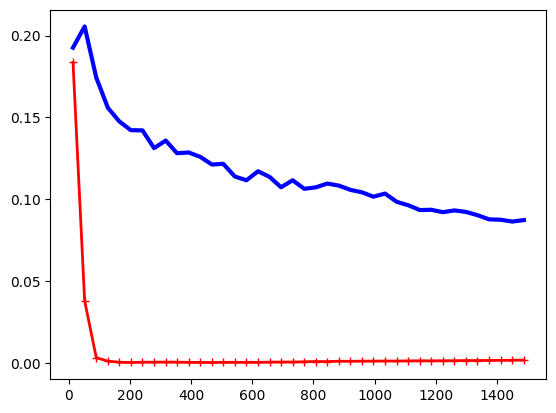

CPU times: user 2.96 s, sys: 1.47 s, total: 4.43 s
Wall time: 8min 58s


In [17]:
%%time
train_and_plot_learning_curve(hgbr_reg)

In [ ]:
%%time

parameters = {
 'histgradientboostingregressor__max_iter': [2000, 5000, 10000],
 'histgradientboostingregressor__learning_rate': [0.001, 0.01, 0.05],
 'histgradientboostingregressor__max_depth' : [10, 25],
 'histgradientboostingregressor__max_leaf_nodes' : [10, 15, 20],
 'histgradientboostingregressor__min_samples_leaf' : [20],
 'histgradientboostingregressor__l2_regularization': [0, 0.1],
 }
#instantiate the gridsearch
hgb_grid = GridSearchCV(
    hgbr_reg, parameters, n_jobs=-1, 
    cv=10, scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False)
)
#fit on the grid 
hgb_grid.fit(X, y)

### SVR Linear

In [25]:
from sklearn.svm import LinearSVR
svr_linear = make_pipeline(preprocessing, LinearSVR(C=1, epsilon=0, max_iter=10_000_000))
svr_linear = TransformedTargetRegressor(svr_linear, transformer=StandardScaler())

In [26]:
%%time
svr_linear_mapes = cross_val_score(svr_linear, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)
pd.Series(svr_linear_mapes).describe()

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:301: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:301: RuntimeWarning: invalid value encountered in log
  return func(X, **(kw_args if kw_args else {}))
/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:301: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:301: RuntimeWarning: invalid value encountered in log
  return func(X, **(kw_args if kw_args else {}))
/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/preprocessing/_function_transf

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/compose/_target.py", line 262, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 726, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 657, in _fit_transform
    return Parallel(n_jobs=self.n_jobs)(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/joblib/parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/joblib/parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 597, in __init__
    self.results = batch()
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/joblib/parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/joblib/parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/utils/fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/pipeline.py", line 446, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/base.py", line 851, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/preprocessing/_data.py", line 824, in fit
    return self.partial_fit(X, y, sample_weight)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/preprocessing/_data.py", line 861, in partial_fit
    X = self._validate_data(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/base.py", line 535, in _validate_data
    X = check_array(X, input_name="X", **check_params)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/utils/validation.py", line 919, in check_array
    _assert_all_finite(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/utils/validation.py", line 161, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains infinity or a value too large for dtype('float64').


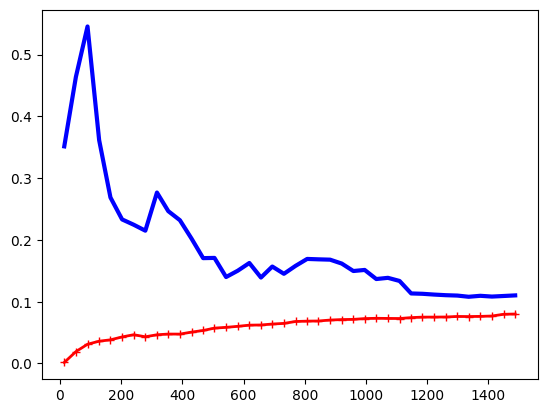

CPU times: user 1.36 s, sys: 631 ms, total: 1.99 s
Wall time: 18.8 s


In [84]:
%%time
train_and_plot_learning_curve(svr_linear)

In [85]:
C_range = [0, 0.01, 0.1, 1, 10, 100]
epsilon_range = [0, 0.01, 0.1, 1, 10]
param_grid = {
    'regressor__linearsvr__epsilon': epsilon_range, 
    'regressor__linearsvr__C': C_range
}

{'regressor__linearsvr__epsilon': [0, 0.01, 0.1, 1, 10],
 'regressor__linearsvr__C': [0.01, 0.1, 1, 10, 100]}

In [86]:
%%time
linear_grid = GridSearchCV(svr_linear, param_grid=param_grid, cv=10, n_jobs=-1, 
                           scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))
linear_grid.fit(X, y)

CPU times: user 703 ms, sys: 177 ms, total: 880 ms
Wall time: 6min 44s


GridSearchCV(cv=10,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                                             ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                                                          SimpleImputer(strategy='median')),
                                                                                                                         ('standardscaler',
                                                                                                                          StandardScaler())]),
                                                                                               transformers=[('cat',
                                                                                                              Pipeline(steps=[('simpleimputer',
                                                                                                                               SimpleImputer(strategy='most_frequent')),
                                                                                                                              ('onehotencoder',
                                                                                                                               On...
                                                                                                              <sklearn.compose._column_transformer.make_column_selector object at 0x7efc95ae4700>)])),
                                                                            ('linearsvr',
                                                                             LinearSVR(C=1,
                                                                                       epsilon=0,
                                                                                       max_iter=10000000))]),
                                                  transformer=StandardScaler()),
             n_jobs=-1,
             param_grid={'regressor__linearsvr__C': [0.01, 0.1, 1, 10, 100],
                         'regressor__linearsvr__epsilon': [0, 0.01, 0.1, 1,
                                                           10]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [87]:
linear_grid.best_params_

{'regressor__linearsvr__C': 0.01, 'regressor__linearsvr__epsilon': 0.1}

In [88]:
linear_grid.best_score_

-0.10120084687102786

In [93]:
%%time

svr_linear = make_pipeline(preprocessing, LinearSVR(C=0.01, epsilon=0.1, max_iter=10_000_000))
svr_linear = TransformedTargetRegressor(svr_linear, transformer=StandardScaler())
svr_linear_mapes = cross_val_score(svr_linear, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)
pd.Series(svr_linear_mapes).describe()

CPU times: user 1.18 s, sys: 4.49 s, total: 5.68 s
Wall time: 390 ms


count    10.000000
mean      0.101153
std       0.019739
min       0.077043
25%       0.084849
50%       0.099276
75%       0.113198
max       0.138966
dtype: float64

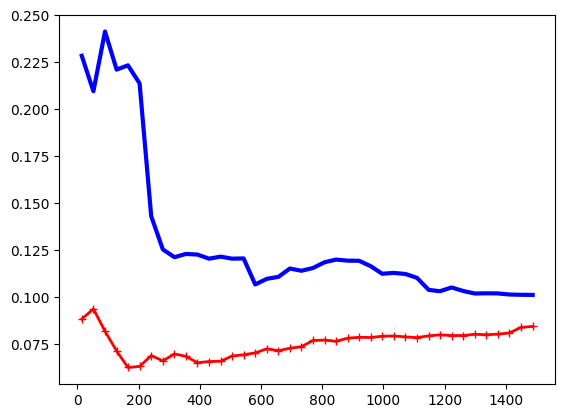

CPU times: user 1.91 s, sys: 1.75 s, total: 3.66 s
Wall time: 2.93 s


In [94]:
%%time
train_and_plot_learning_curve(svr_linear)

### SVR RBF

In [32]:
from sklearn.svm import SVR

In [249]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [258]:
%%time
param_distributions = [
    {'regressor__svr__gamma': randint(0, 50), 'regressor__svr__C': randint(1, 100)},
]
rnd_search = RandomizedSearchCV(
    svr, param_distributions=param_distributions, n_iter=10, cv=10,
    scoring=make_scorer(mean_absolute_percentage_error), random_state=42)

rnd_result = rnd_search.fit(X, y)

CPU times: user 18.7 s, sys: 0 ns, total: 18.7 s
Wall time: 18.7 s


In [259]:
rnd_result.best_params_

{'regressor__svr__C': 22, 'regressor__svr__gamma': 1}

In [33]:
%%time
svr_rbf = make_pipeline(preprocessing, SVR(kernel="rbf"))
svr_rbf = TransformedTargetRegressor(svr_rbf, transformer=StandardScaler())
svr_rbf_mapes = cross_val_score(svr_rbf, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)

CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.18 s


In [35]:
pd.Series(svr_rbf_mapes).describe()

count    10.000000
mean      0.085001
std       0.012212
min       0.069718
25%       0.075149
50%       0.083982
75%       0.093441
max       0.106791
dtype: float64

# SVR POLY

In [36]:
%%time
svr_poly4 = make_pipeline(preprocessing, SVR(kernel="poly", degree=3))
svr_poly4 = TransformedTargetRegressor(svr_poly4, transformer=StandardScaler())
svr_poly4_mapes = cross_val_score(svr_poly4, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10, n_jobs=-1)

CPU times: user 27.8 ms, sys: 10.4 ms, total: 38.2 ms
Wall time: 255 ms


In [37]:
pd.Series(svr_poly4_mapes).describe()

count    10.000000
mean      0.130423
std       0.031375
min       0.095101
25%       0.107975
50%       0.125624
75%       0.141313
max       0.200588
dtype: float64

# SVR Sigmoid

In [39]:
%%time
svr_sigmoid = make_pipeline(preprocessing, SVR(kernel="sigmoid"))
svr_sigmoid = TransformedTargetRegressor(svr_sigmoid, transformer=StandardScaler())

CPU times: user 22 µs, sys: 10 µs, total: 32 µs
Wall time: 35 µs


In [40]:
svr_sigmoid_mapes = cross_val_score(svr_sigmoid, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10, n_jobs=-1)
pd.Series(svr_sigmoid_mapes).describe()

count    10.000000
mean      1.641739
std       0.792136
min       0.792802
25%       1.032438
50%       1.402428
75%       1.919017
max       3.071608
dtype: float64

# Red neuronal

In [41]:
from sklearn.neural_network import MLPRegressor

In [42]:
%%time
nn = make_pipeline(preprocessing, MLPRegressor(hidden_layer_sizes=(100, 50, 20), 
                                               early_stopping=True, 
                                               learning_rate='invscaling', random_state=42, max_iter=10_000))
nn = TransformedTargetRegressor(nn, transformer=StandardScaler())
nn_mapes = cross_val_score(nn, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)

CPU times: user 24.7 s, sys: 60 s, total: 1min 24s
Wall time: 5.5 s


In [43]:
pd.Series(nn_mapes).describe()

count    10.000000
mean      0.095718
std       0.014193
min       0.071029
25%       0.089459
50%       0.091929
75%       0.106662
max       0.116196
dtype: float64

In [ ]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["floor_number", "height"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline) 